# Sea Ice Diagnostics in ACCESS-ESM1.6

As far as possible, the default configurations of ACCESS-ESM1.6 output sea ice diagnostics in 
the format requested for CMIP7 as native output. This page describes the availability and interpretation 
of these diagnostics available in ACCESS-ESM1.6

### Masking over time and space


It's import to note that CMIP 6/7 sea ice diagnostics are averaged using two different methods, as described in Notz et al. 2016:

- _extensive_ : for variables proportional to sea ice concentation (area fraction), these are averaged over all time and ocean cells. These are marked with the `cell_methods` : `area: mean where sea time: mean`

- _intensive_ : for variables not proportional to sea ice concentration, these are averaged only when there is sea ice in the cell. These are marked with `cell_methods`: `area: time: mean where sea_ice (mask=siconc)`. 

Using `siflcondtop` as an example, intensive diagnostics are calculated as: 

$$ siflcondtop = \frac{\displaystyle\sum_{n=0}^N (aice * fcondtop)}{\displaystyle\sum_{n=0}^N (aice)} $$

where N is the number of timesteps in the averaging interval, `aice` is the sea ice fraction in the timestep, and `fcondtop` is the conductive heat flux in that timestep.

Therefore intensive variables should be interpreted as the average over only the proportion of the averaging interval that sea ice was present. It is possible to convert between extensive and intensive variables by multiplying by sea ice conentration averaged at the same frequency, which returns a grid cell average for the variable:

$$ siflcondtop * \frac{siconc}{100} = \frac{\displaystyle\sum_{n=0}^N (aice * fcondtop)}{\displaystyle\sum_{n=0}^N (aice)} *  \frac{\displaystyle\sum_{n=0}^N (aice)} {N} 
= \frac{\displaystyle\sum_{n=0}^N (aice * fcondtop)} {N}
$$

The use of _intensive_ variables has the impact that sometimes diagnostics may have the
same or similar descriptions but be masked differently.

e.g. 

There are seperate ocean and sea ice variables labelled *Water Flux into Sea Water Due to Sea Ice Thermodynamics* 
 - siflfwbot is masked only where sea_ice (in time and space)
 - fsithem (as an ocean diagnostic) is in all wet cells for all time
 
both are reported in `kg m-2 s-1` but the areas and time they are calculated for are different

*Thickness*
- sivol is Sea-Ice Volume per Area, calculated using grid cell area
- sithick is a true Sea-Ice Thickness (alternative description would be Sea Ice Volume per Sea Ice Area)

both are repored in `m`

In the sections below, we provide some general comment and validation of diagnostics, split into groupings by diagnostic purpose

### Load Data

To demonstrate some concepts, we are going to load some data.

In [1]:
PATH = "/g/data/tm70/as2285/payu/esm1.6/401/401-dev-preindustrial+concentrations/archive/output000/"

import xarray as xr
import cf_xarray
from matplotlib import pyplot as plt

In [2]:
daily_ds = xr.open_mfdataset(f'{PATH}/ice/iceh-1daily-mean_*.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True))

monthly_ds = xr.open_mfdataset(f'{PATH}/ice/iceh-1monthly-mean_*.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True))

ds = monthly_ds.isel(time=0)

In [3]:
# divide hemishperes exactly
NJ = len(ds.nj)
sh = {'slice':slice(0,int(NJ/2)), 'name':'sh', 'title':'Antarctic'}
nh = {'slice':slice(int(NJ/2),None), 'name':'nh', 'title':'Arctic'}

## Mass / Concentrations

The CICE5 configuration of ACCESS-ESM1.6 uses [fixed densities](https://github.com/ACCESS-NRI/cice5/blob/62dcb7ee19f6e0a71d4b8e3e548b8cece0b930cf/drivers/access/ice_constants.F90#L22-L29) for sea ice, sea water and snow:

In [4]:
rhos      = 330.0  # density of snow (kg/m^3)
rhoi      = 917.0  # density of ice (kg/m^3)
rhow      = 1026.0 # density of seawater (kg/m^3)

You can also check these through the diagnostics, for example, sea ice mass divided by volume shows constant density:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


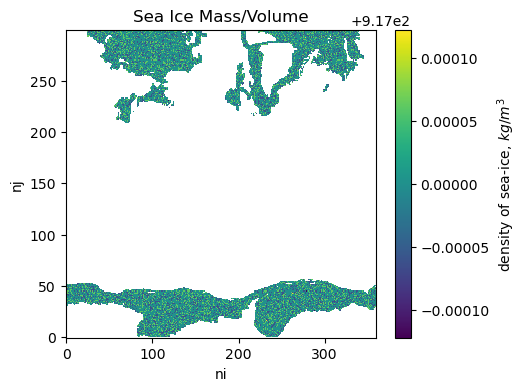

In [5]:
plt.figure(figsize=(5,4))
(ds.simass/ds.sivol).plot(cbar_kwargs={'label':'density of sea-ice, $kg/m^3$'})
plt.title('Sea Ice Mass/Volume')
plt.show()

Using these densities, mass and volume terms balance : 

- $sivol*rhoi = simass$  (sivol and simass are extensive)
- $sisnthick* \frac{siconc}{100}*rhos = sisnmass$. (sisnthick is intensive and sisnmass is extensive)

ACCESS-ESM1.6 uses a [fixed salinity](https://github.com/ACCESS-NRI/access-esm1.6-configs/blob/c150adbad53b3dc8ed4079fe2136cbb767fa0a63/ice/cice_in.nml#L46) 
for sea ice of 4 g/kg. Therefore: 

- $sisalt = simass * 0.004$


Sea ice freeboad, thickness and snow thickness should balance to rounding error following Archimedes
principal of buoyancy. 
On the LHS we have mass of snow and sea ice together. 
On the RHS we have mass of sea water displaced, calculated as the volume of sea ice below the surface multiplied by density of water

$simass+sisnmass = (sithick-sifb)*rhow$

sithick, sisnthick, sifb are all weighted by ice fraction in time, and presented as $kg/m^2$

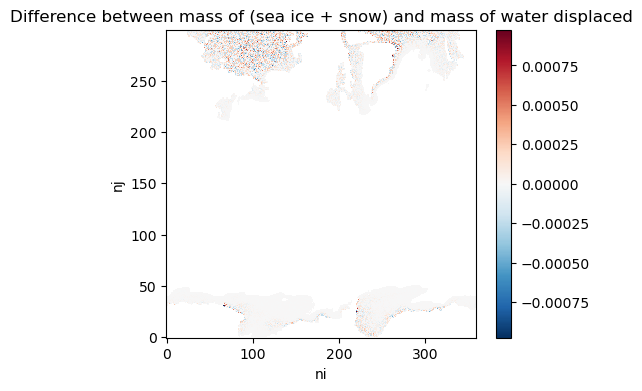

In [6]:
plt.figure(figsize=(5,4))
(ds.simass+ds.sisnmass-(ds.sithick-ds.sifb)*ds.siconc/100*rhow).plot()
plt.title('Difference between mass of (sea ice + snow) and mass of water displaced')
plt.show()

## Temperatures

Heat flux and sea ice surface temperature are calculated within the atmosphere model, and are not prognostic in the sea ice model component. Therefore sea ice surface temperature (`sitemptop`) and snow-ice interface temperature (`sitempsnic`) are not available as sea ice diagnostics. There is an sea ice surface temperature in the atmosphere diagnostics (`surface_temperature` - UM stash code - s00i508). This is an average of the surface temperature of the sea ice portion of the cell only. This is different to the CMIP variable for `sitemptop` (which should be weighted by sea ice concentration over time as its an intensive variable).

(N.B. `s00i508` is the surface temperature over sea ice only, even when sea ice only fill parts of the grid cell. However for open ocean without sea ice, the diagnostic is arbitrarily set to -1.8°C - the approximate freezing point of the ocean. The open ocean and land values for this diagnostic don't have a realistic meaning, and should be masked out for analysis.)

In [7]:
atm_ds = xr.open_mfdataset(f'{PATH}/atmosphere/netCDF/aiihca.pa-*01_mon.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True))

Text(0.5, 1.0, 'Sea ice surface temperature diagnostic')

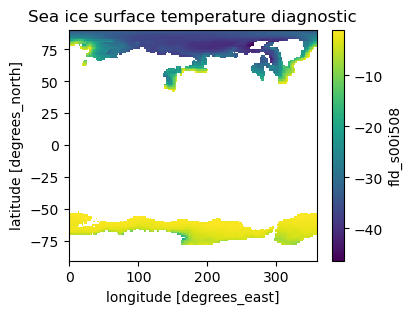

In [8]:
plt.figure(figsize=(4,3))
((atm_ds['fld_s00i508'].where(atm_ds['fld_s00i031']>0))-273.15).plot() #mask where sea ice area fraction is 0
plt.title('Sea ice surface temperature diagnostic')

Sea ice bottom temperature (`sitempbot`) is available and is equal to the freezing point of sea water. The freezing point is calculated as :

$Tf = - sss * depressT$ where [depressT](https://github.com/ACCESS-NRI/cice5/blob/d8e6797b4b576fa953fcb7704bc62fed4f480017/drivers/access/ice_constants.F90#L42) is 0.054°/ppt

<!-- depressT is hardcoded into MOM5 at the same value - see https://github.com/ACCESS-NRI/MOM5/blob/627a321f7490afc69b4a8e777992bcfb1f58b5ae/src/mom5/ocean_tracers/ocean_frazil.F90#L450C6-L450C8 -->

## Heat Fluxes

There is no process for penetrating shortwave through sea ice (`sifswdbot` is zero). 
The sea ice thermodynamic model is zero-layer, so top and bottom conductive heat flux are equal (`siflcondtop = siflcondbot`)

There is no heat flux diagnostic for frazil melt potential but there is a diagnostic for
_Sea-Ice Mass Change Through Growth in Supercooled Open Water (Frazil)_ (`sidmassgrowthwat`)

We report surface fluxes as atmospheric diagnostics only:

| Var Name| Description|Stash Code|
|----|:----|----|
|rsds|Surface Downwelling Shortwave Radiation|s01i235|
|rsus|Surface Upwelling Shortwave Radiation| * |
|rlds|Surface Downwelling Longwave Radiation|s02i207|
|rlus|Surface Upwelling Longwave Radiation| * |
|hfss|Surface Upward Sensible Heat Flux| s03i217 |
|hfls|Surface Upward Latent Heat Flux| s03i234 |

These are extensive diagnostics on the atmosphere grid, which include the ocean, sea ice and land fraction in the same variable. The intensive form, as requested for SIMIP variables, is not available (i.e. 
_sifllattop, sifllwdtop, sifllwutop, siflsenstop, siflswdtop, siflswutop_ are not provided). Where marked with `*` - variables are only available through post-processing.

The heat fluxes `siflsensbot`, `siflcondtop` and `siflcondbot` are available (note they are intensive diagnostics)

## Salt / Water Fluxes

The sea ice diagnostic `siflfwbot` (Freshwater Flux from Sea Ice) is intensive, and different from
the ocean diagnostic `fsitherm` (Water Flux into Sea Water Due to Sea Ice Thermodynamics) 
which is extensive. We attempt to balance sea and ice diagnostics of salt and water fluxes below. They are close but not an exact match. 

We use split `fsitherm` into `wfimelt` and `wfiform` for water fluxes associated with melting (of sea ice and snow) and forming sea ice. (i.e. $fsitherm = wfimelt + wfiform$)

Open some ocean diagnostics:

In [9]:
wfimelt = xr.open_mfdataset(f'{PATH}/ocean/ocean-2d-wfimelt-1monthly-mean-ym_*_01.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True), decode_timedelta=True)
wfiform = xr.open_mfdataset(f'{PATH}/ocean/ocean-2d-wfiform-1monthly-mean-ym_*_01.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True), decode_timedelta=True)
ocean_tarea = xr.open_dataset(f'{PATH}/ocean/ocean-2d-area_t.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True))

First we compare ocean and sea ice diganostics for sea ice formation

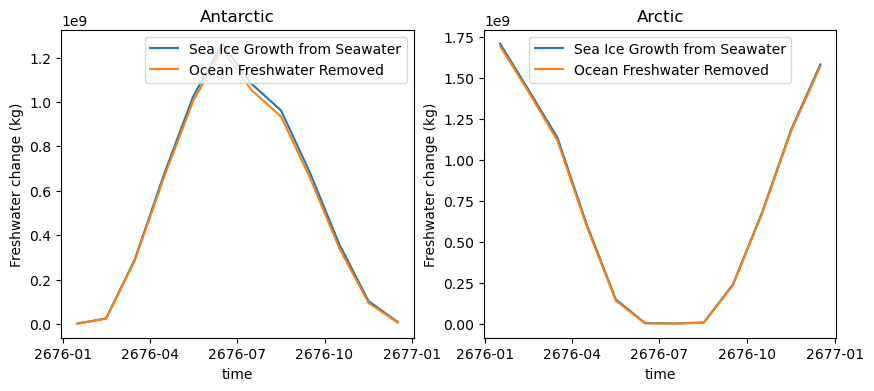

In [10]:
plt.figure(figsize=(10,4))
for i,hemi in enumerate([sh,nh], start =1):
    plt.subplot(1,2,i)
    ((monthly_ds.sidmassgrowthwat+monthly_ds.sidmassgrowthbot)*monthly_ds.tarea
        ).sel(nj=hemi['slice']).sum(['ni','nj']).plot(label='Sea Ice Growth from Seawater')
         
    (-1*wfiform.wfiform*ocean_tarea.area_t
        ).isel(yt_ocean=hemi['slice']).sum(['xt_ocean','yt_ocean']).plot(label='Ocean Freshwater Removed')

    plt.legend()
    plt.ylabel('Freshwater change (kg)')
    plt.title(hemi['title'])

plt.show()


And we compare ocean and sea ice diganostics for melt

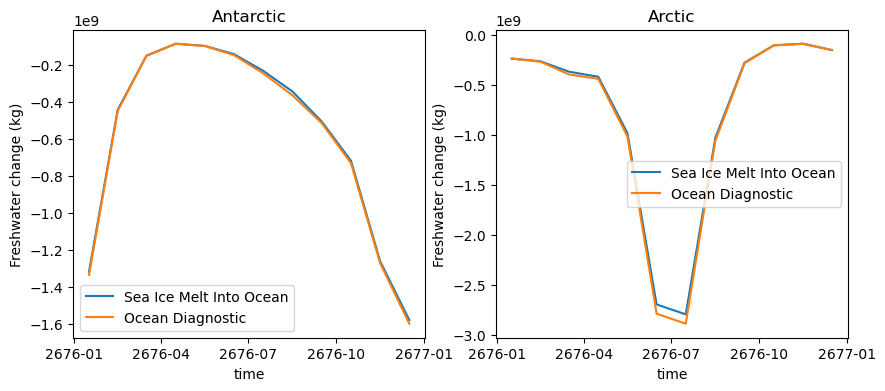

In [11]:
plt.figure(figsize=(10,4))
for i,hemi in enumerate([sh,nh], start =1):
    plt.subplot(1,2,i)
    ((
     monthly_ds.sisndmassmelt
     + monthly_ds.sidmassmelttop
     + monthly_ds.sidmassmeltbot
     + monthly_ds.sidmassmeltlat
     )*monthly_ds.tarea).sel(nj=hemi['slice']).sum(['ni','nj']).plot(label='Sea Ice Melt Into Ocean')
     
    (-1*wfimelt.wfimelt*ocean_tarea.area_t
        ).isel(yt_ocean=hemi['slice']).sum(['xt_ocean','yt_ocean']).plot(label='Ocean Diagnostic')

    plt.legend()
    plt.ylabel('Freshwater change (kg)')
    plt.title(hemi['title'])

plt.show()

Salt is only transferred between the ocean and sea ice, there is no salt fluxes into or out of the atmosphere. ACCESS-ESM1.6 uses fixed salinity in sea ice, therefore all mass change in sea ice has a corresponding salt flux in the ocean (even though mass change can occur without a freshwater flux, e.g. if due to sno->ice conversion or evaporation/sublimation). 

The sea ice diagnostic `sidmassth` equals the ocean diagnostic `sfc_salt_flux_ice` divided by 0.004. This is should be true in all areas - we see differences in the order of $1e-6 kg/m^2$ (~5%) in cells around the outer ice edge, possibly as the sea ice and ocean diagnostics will be [offset](https://github.com/ACCESS-NRI/access-esm1.6-configs/pull/234#issuecomment-3752924581) by one model timestep from each other.

In [12]:
salt = xr.open_mfdataset(f'{PATH}/ocean/ocean-2d-sfc_salt_flux_ice-1monthly-mean-ym_*_01.nc', decode_times=xr.coders.CFDatetimeCoder(use_cftime=True), decode_timedelta=True)

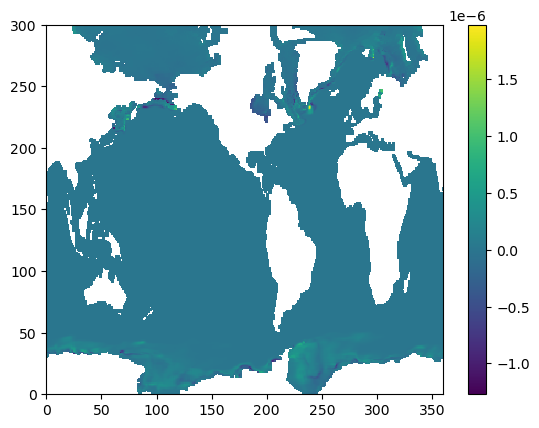

In [13]:
plt.pcolor((monthly_ds.sidmassth.isel(time=0).values+(salt.sfc_salt_flux_ice/0.004).isel(time=0).values))
plt.colorbar()

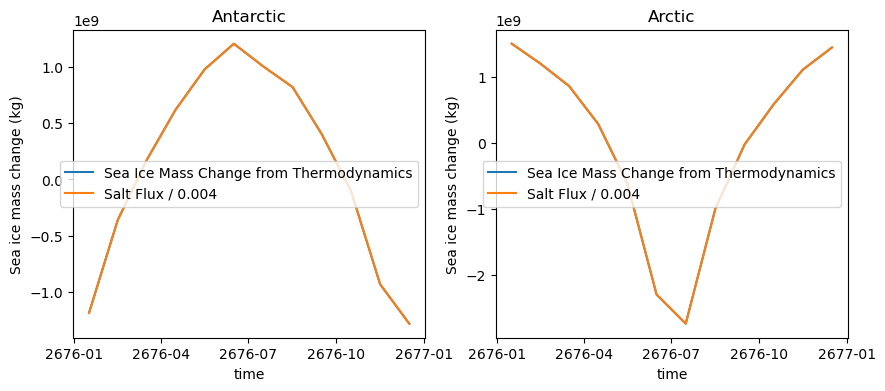

In [14]:
plt.figure(figsize=(10,4))
for i,hemi in enumerate([sh,nh], start=1):
    plt.subplot(1,2,i)
    (monthly_ds.sidmassth*monthly_ds.tarea).sel(nj=hemi['slice']).sum(['ni','nj']).plot(label='Sea Ice Mass Change from Thermodynamics')
    
    (-1*salt.sfc_salt_flux_ice/0.004*ocean_tarea.area_t).isel(yt_ocean=hemi['slice']).sum(['xt_ocean','yt_ocean']).plot(label='Salt Flux / 0.004')

    plt.legend()
    plt.ylabel('Sea ice mass change (kg)')
    plt.title(hemi['title'])

plt.show()

## Dynamics

By convention, diagnostics follow the same spatial discretisation as prognostic calculations within the model. CICE5 uses a generalised orthogonal B-grid as described in Murray 1996 or Smith, Korta and Meltz 1995. The ice and snow area, volume and energy are given at the centre of the cell, whilst velocity is defined at the corners. For diagnostics which combined quantities at cell centres and corners, e.g. mass transport, these are reported at the centre of the cell.

At cell centers: 

| Var Name| Description|
|----|:----|
|sidmassdyn	    |Sea-Ice Mass Change from Dynamics|
|sidmasstranx	|X-Component of Sea-Ice Mass Transport|
|sidmasstrany	|Y-Component of Sea-Ice Mass Transport|

`sidmassdyn` is the change in mass in a cell due to dynamics. Sea ice mass transport (`sidmasstran`)
is calculated as a rate of transport through the right (positive x) and top (positive y) edge of the cell.
The `sidmasstran` terms are calculated as $velocity * celledgelength*rhoi$, where velocity is a mean of the 
velocity in the relevant corners of the cell to reflect an average velocity across the edge.

These quantities are all reported on the corner points :

| Var Name| Description|
|----|:----|
|sicompstren		|	Compressive Sea Ice Strength |
|sistrxdtop		|	X-Component of Atmospheric Stress on Sea Ice |
|sistrxubot		|	X-Component of Ocean Stress on Sea Ice |
|sistrydtop		|	Y-Component of Atmospheric Stress on Sea Ice |
|sistryubot		|	Y-Component of Ocean Stress on Sea Ice |

Sea ice mass change from dynamics sums to zero (with rounding error) for each hemisphere as sea ice mass is conserved during sea ice dynamics processes.

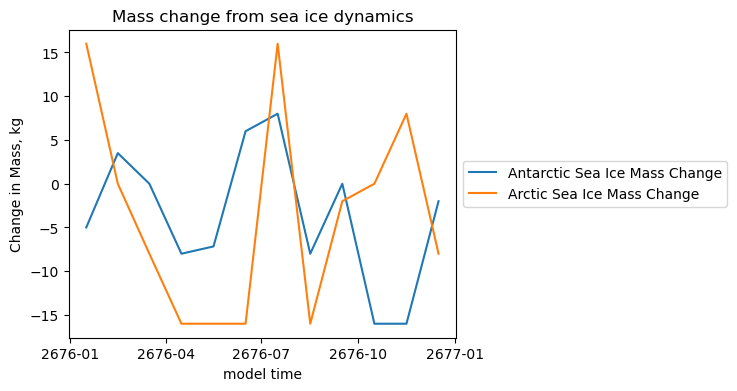

In [15]:
plt.figure(figsize=(5,4))
for hemi in [sh,nh]:
    (monthly_ds.sidmassdyn*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sea Ice Mass Change')
plt.ylabel('Change in Mass, kg')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Mass change from sea ice dynamics')
plt.show()

<!-- I would expect snow mass is also conserved by sea ice dynamics, however `sisndmassdyn` does not sum to zero. Nor does dvsdtd )-->


Snow is not conserved during sea ice dynamics

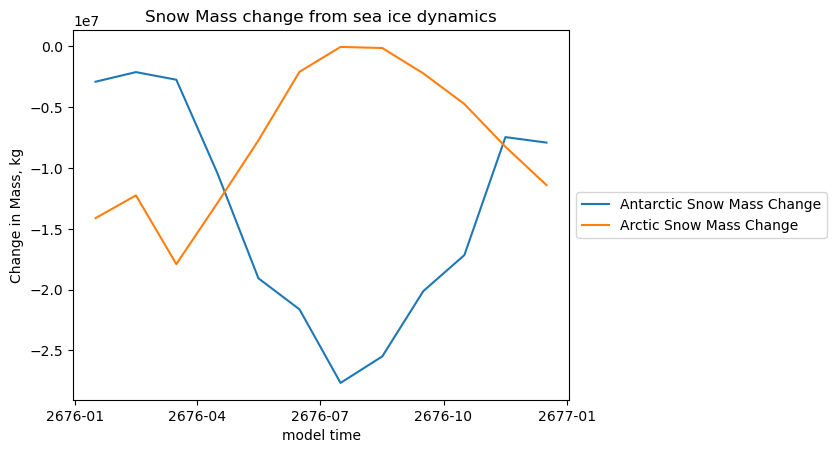

In [16]:
for hemi in [sh,nh]:
    (monthly_ds.sisndmassdyn*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Snow Mass Change')

plt.ylabel('Change in Mass, kg')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Snow Mass change from sea ice dynamics')
plt.show()

## Thermodynamics

The diagnostic for evaporation and sublimation can be positive in some model cells (i.e. mass gain) whilst as the sum for each hemisphere is negative (mass loss). This is for two reasons, firstly (`sidmassevapsubl`) can include condensation and deposition (desublimation). In addition, the evaporation flux is calculated within the atmosphere model, on the atmosphere grid, and conservatively regridded to the sea ice grid. Conservative regridding can lead to sign changes in some cells.

Diagnostics for Sea ice mass change are extensive

| Var Name| Description|
|----|:----|
| sidmassth |		Sea-Ice Mass Change from Thermodynamics |

is the sum of 

| Var Name| Description|
|----|:----|
|sidmassgrowthbot|	Sea-Ice Mass Change Through Basal Growth |
|sidmassgrowthsi|		Sea-Ice Mass Change Through Snow-to-Ice Conversion |
|sidmassgrowthwat|	Sea-Ice Mass Change Through Growth in Supercooled Open Water (Frazil) |
|sidmassmeltbot|		Sea-Ice Mass Change Through Bottom Melting |
|sidmassmeltlat|		Sea-Ice Mass Change Through Lateral Melting|
|sidmassmelttop|	    Sea-Ice Mass Change Through Surface Melting|
|sidmassevapsubl|	Sea-Ice Mass Change Through Evaporation and Sublimation|


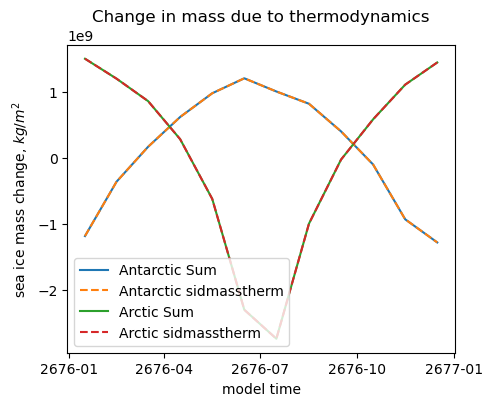

In [17]:
plt.figure(figsize=(5,4))
for hemi in [sh,nh]:
    ((   monthly_ds.sidmassgrowthwat
     + monthly_ds.sidmassgrowthbot
     + monthly_ds.sidmassgrowthsi
     + monthly_ds.sidmassevapsubl
     + monthly_ds.sidmassmelttop
     + monthly_ds.sidmassmeltbot
     + monthly_ds.sidmassmeltlat
    )*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')
    (monthly_ds.sidmassth*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(
        label = hemi['title']+' sidmasstherm', linestyle='--')

plt.title('Change in mass due to thermodynamics')
plt.ylabel('sea ice mass change, $kg/m^2$')
plt.legend()
plt.show()

Similarly, `siflfwbot` should balance with the relevant `sidmass` terms. This is not an exact match, so maybe the sidmass terms are missing snow into the ocean due to ridging and rain on sea-ice which do get included into `siflfwbot`. Rain passes straight through the sea ice and into the ocean, so `sipr` is not provided, however `siflfwbot` includes rain passing through the sea-ice.

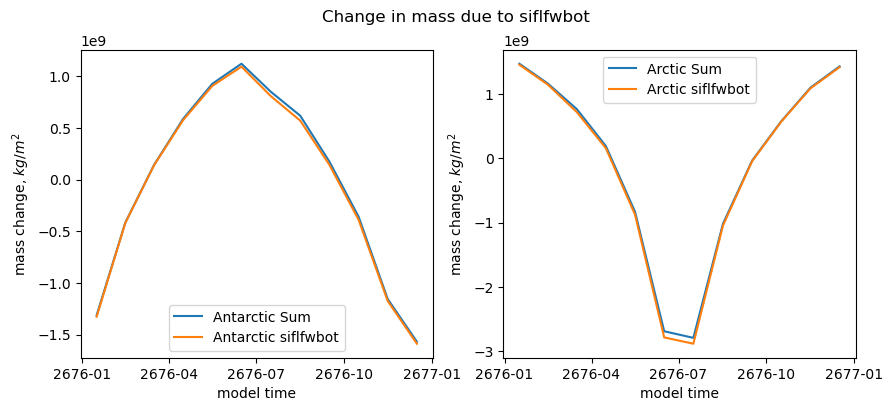

In [18]:
plt.figure(figsize=(10,4))
for i,hemi in enumerate([sh,nh], start=1):
    plt.subplot(1,2,i)

    ((   monthly_ds.sidmassgrowthwat
     + monthly_ds.sidmassgrowthbot
     + monthly_ds.sidmassmelttop
     + monthly_ds.sidmassmeltbot
     + monthly_ds.sidmassmeltlat
     + monthly_ds.sisndmassmelt
    )*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')
    (-1*monthly_ds.siflfwbot*monthly_ds.siconc/100*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' siflfwbot')
    
    plt.ylabel('mass change, $kg/m^2$')
    plt.legend()

plt.suptitle('Change in mass due to siflfwbot')
plt.show()

## Snow

We do not provide snow area fraction (`sisnconc`) or snow thickness (`sisnthick`) as they are prognostic only in the atmosphere model.

There is no process for blown snow on sea ice, so `sisndmasswind` (Snow Mass Rate of Change Through Wind Drift of Snow) is not reported. There are no melt ponds.

Variables for snow are generally masked for when there is sea ice (i.e. intensive)


There is no overall CMIP diagnostic for snow mass rate of change, however the sum of the following diagnostics should be the rate of snow accumulation for each hemisphere. 

| Var Name| Description|
|----|:----|
|sisndmassmelt		|Snow Mass Rate of Change Through Melt|
|sisndmasssi		|    Snow Mass Rate of Change Through Snow-to-Ice Conversion|
|sisndmasssnf		|Snow Mass Change Through Snowfall|
|sisndmasssubl		|Snow Mass Rate of Change Through Evaporation or Sublimation|

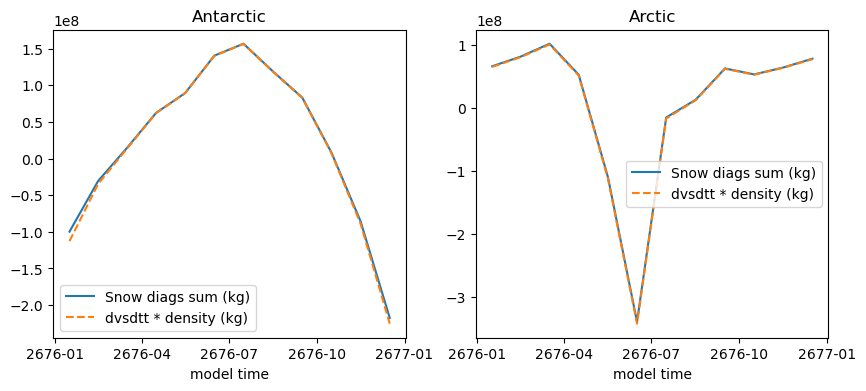

In [19]:
plt.figure(figsize=(10,4))
for i,hemi in enumerate([sh,nh], start=1):
    plt.subplot(1,2,i)

    (( + monthly_ds.sisndmassmelt
      + monthly_ds.sisndmasssi
      + monthly_ds.sisndmasssnf
      + monthly_ds.sisndmasssubl
     )*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = 'Snow diags sum (kg)')
    ((monthly_ds.dvsdtt/86400*rhos/100)*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(
        label = 'dvsdtt * density (kg)', linestyle='--')
    plt.legend()
    plt.title(hemi['title'])
plt.show()



In CICE, Snow-to-Ice conversion only occurs when the weight of the snow pushes the sea ice below the water level 
(i.e. freeboard is negative) and the mass of snow is directly converted to a mass of sea ice. The process is adiabiatic,
there is no energy exchanged in the process. However `sidmassgrowthsi` is not equal to `sisndmasssi` as `sidmassgrowthsi` is extensive and `sisndmasssi` is intensive.


### Hemispheric Scalars

Diagnostics which do not have a spatial coordinate are only available via post-processings:

| Var Name| Description|
|----|:----|
|siareaacrossline			|	Sea-Ice Area Flux Through Straits|
|simassacrossline			|	Sea-Ice Mass Flux Through Straits|
|siarean		|	Sea-Ice Area North|
|siareas		|	Sea-Ice Area South|
|siextentn		|Sea-Ice Extent North|
|siextents		|Sea-Ice Extent South|
|sisnmassn		|	Snow Mass on Sea Ice North|
|sisnmasss		|	Snow Mass on Sea Ice South|
|sivoln		|	Sea-Ice Volume North|
|sivols		|	Sea-Ice Volume South|